## Sentinel2 scenes for Cadia -test

This notebook takes polygons, loads sentinel2 data and saves the output to geotiff.

**Before you run this notebook:** You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

`module use /g/data/v10/public/modules/modulefiles`

`module load dea`

**Date**: Oct 2018.

**Author**: Claire Krause, Bex Dunn

In [7]:
%matplotlib inline
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import numpy as np

import sys
import os
# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('../../10_Scripts'))
import DEAPlotting
import DEADataHandling

dc = Datacube(app='Sentinel2')

## See what Sentinel 2 products are currently available

In [8]:
products = dc.list_products()
display_columns = ['name', 'description', 'instrument',
                   'platform', 'product_type', 'crs', 'resolution']
sentinel_products = products[products['instrument'] == 'MSI'][display_columns]
sentinel_products

,name,description,instrument,platform,product_type,crs,resolution
id,,,,,,,
90,s2a_ard_granule,Sentinel-2A MSI ARD - NBAR NBART and Pixel Qua...,MSI,SENTINEL_2A,S2MSIARD,NaN,NaN
92,s2a_level1c_granule,Sentinel-2A Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2A,S2MSI1C,NaN,NaN
91,s2b_ard_granule,Sentinel-2B MSI ARD - NBAR NBART and Pixel Qua...,MSI,SENTINEL_2B,S2MSIARD,NaN,NaN
93,s2b_level1c_granule,Sentinel-2B Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2B,S2MSI1C,NaN,NaN


There are two spectral Sentinel satellites currently in DEA; **Sentinel-2A** and **Sentinel-2B**. Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017.

Both of the Sentinel 2 satellites carries an innovative wide swath high-resolution multispectral imager with 13 spectral bands. The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery. Together they cover all Earth's land surfaces, large islands, inland and coastal waters every five days at the equator.

For more information on the Sentinel 2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-2). 

### query

#### shapefile query

In [9]:
# shape_file = '/g/data1a/r78/rjd547/groundwater_activities/East_Kimberley/shapefiles/AEM_detailed_extent_Keep_clip.shp'
# GEOM, SHAPE_NAME = DEADataHandling.open_polygon_from_shapefile(shape_file)
# start_of_epoch, end_of_epoch=('2017-06-01', '2017-07-31')

# query = {
#     'time': (start_of_epoch, end_of_epoch), 
#     'geopolygon': GEOM,
#     'output_crs': 'EPSG:3577',
#     'resolution': (-10, 10)
# }

#### The event happened "in the late afternoon on Friday [9 March 2018]", see https://www.smh.com.au/national/nsw/work-suspended-after-dam-collapses-at-australia-s-largest-gold-mines-20180310-p4z3s7.html Cadia tailings dam is located at 149.000° E, 33.506° S. The collapse happened at the southwestern part of the dam. From Sentinel-2 images, CGG's NPA Satellite Mapping team conclude that "the dam failure occurred in two phases. The initial dam failure took place at ~7pm (local time) on 9th March (red dashed polygon) as reported, however a secondary failure then occurred on 11th March (yellow dashed polygon)", see https://www.linkedin.com/pulse/cadia-mine-tailings-failure-digging-deeper-using-earth-adam-thomas/

In [10]:
#uncomment this to use lat long instead
query = {
        'lat': (-33.40, -35.60),
        'lon': (148.80, 149.20),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time': ('2018-03-01', '2018-03-15')
        }

In [11]:
## now load the data

In [12]:
CADIA= dc.load(product='s2a_ard_granule', group_by='solar_day', **query)
#ORD_BON= dc.load(product='s2a_ard_granule', group_by='solar_day', **query2)

MemoryError: 

### See what came back from the extraction

In [ ]:
CADIA

## About Sentinel 2 bands
Sentinel 2 satellites have 13 spectral channels:

| Sentinel 2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `nbar(t)_coastal_aerosol` | 1 | 443 | 60 | 20 |
| Blue | `nbar(t)_blue` | 2 | 490 | 10 | 65 |
| Green | `nbar(t)_green` | 3 | 560 | 10 | 35 |
| Red | `nbar(t)_red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `nbar(t)_red_edge_1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_3` | 7 | 783 | 20 | 20 |
| NIR | `nbar(t)_nir_1` | 8 | 842 | 10 | 115 |
| Narrow NIR | `nbar(t)_nir_2` | 8A | 865 | 20 | 20 |
| Water vapour | N/A | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | N/A | 10 | 1375 | 60 | 20 |
| SWIR | `nbar(t)_swir_2` | 11 | 1610 | 20 | 90 |
| SWIR | `nbar(t)_swir_3` | 12 | 2190 | 20 | 180 |

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

![Sentinel 2 bands](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)

**Note** There are a number of additional datasets that are alse returned from our query. These are a combination of datasets used in the correction process, and layers relating to pixel quality. We will explore the pixel quality layers below.

## Plot this scene up as true colour image

True colour images approximate what the human eye sees when looking at a landscape. Note that the function used for this true colour plot enhances the contrast between the bands, resulting in a colour-enhanced image.

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89a64aeda0>)

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


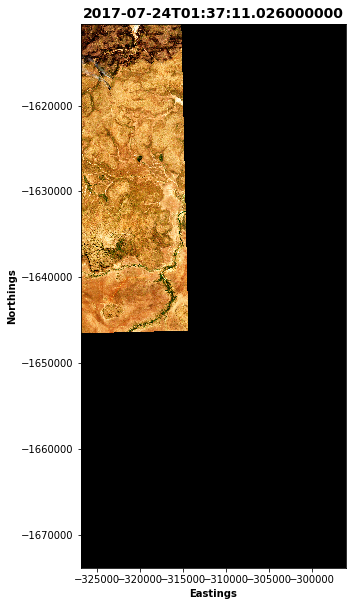

In [13]:
DEAPlotting.three_band_image(CADIA, bands=['nbar_red', 'nbar_green', 'nbar_blue'],
                             contrast_enhance=True, time=2)

## Plot this scene up as false colour image

This plot uses the SWIR, NIR and green bands to accentuate the presence of water in the landscape.

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89a41fc0b8>)

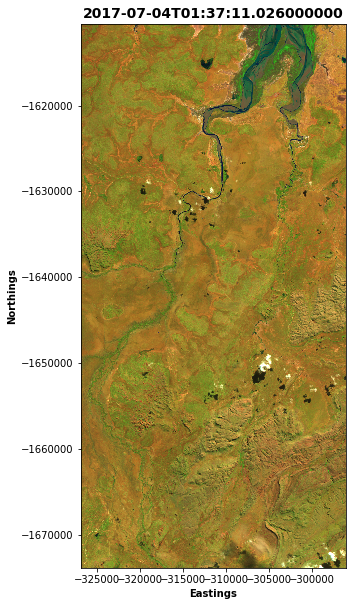

In [14]:
DEAPlotting.three_band_image(
    CADIA, bands=['nbar_swir_2', 'nbar_nir_1', 'nbar_green'], time=1)

## Compare some scenes side-by-side

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<module 'matplotlib.pyplot' from '/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/matplotlib/pyplot.py'>,
 <Figure size 720x720 with 3 Axes>)

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


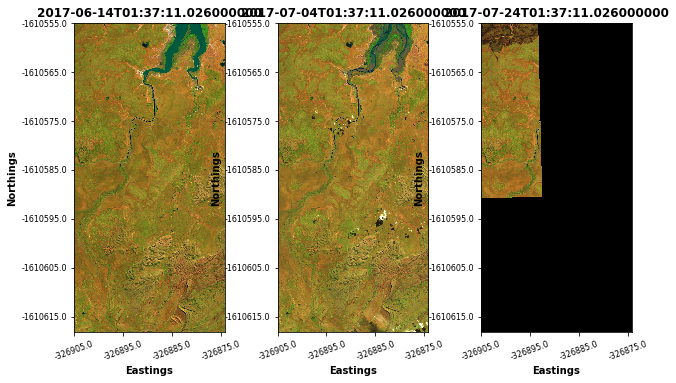

In [16]:
DEAPlotting.three_band_image_subplots(CADIA, bands=['nbar_swir_2', 'nbar_nir_1', 'nbar_green'],
                                      num_cols=3, figsize=[10, 10], wspace=0.35)

In [51]:
filename='/g/data/r78/rjd547/groundwater_activities/East_Kimberley/Sentinel2/'

### write time into filename

In [67]:

print(filename2)

/g/data/r78/rjd547/groundwater_activities/East_Kimberley/Sentinel2/_s2_2017-07-24.tif


In [66]:
date_s2 = str(CADIA.isel(time=i).time.data)[:-19]
print(date_s2)

2017-07-24


### Now we drop the masking bands as they're uint8 and not helpful

In [77]:
CADIA = CADIA.drop(['terrain_shadow', 'fmask','nbar_contiguity','nbart_contiguity'])

CADIA.isel(time=i)

<xarray.Dataset>
Dimensions:                (x: 3083, y: 6325)
Coordinates:
    time                   datetime64[ns] 2017-06-14T01:37:11.026000
  * y                      (y) float64 -1.611e+06 -1.611e+06 -1.611e+06 ...
  * x                      (x) float64 -3.269e+05 -3.269e+05 -3.269e+05 ...
Data variables:
    azimuthal_exiting      (y, x) float32 56.126434 34.914062 34.914062 ...
    azimuthal_incident     (y, x) float32 139.92375 115.665016 115.665016 ...
    exiting                (y, x) float32 7.220398 7.6523995 7.6523995 ...
    incident               (y, x) float32 44.33301 44.735336 44.735336 ...
    relative_azimuth       (y, x) float32 64.13543 64.13562 64.13562 64.1358 ...
    relative_slope         (y, x) float32 83.79732 80.75095 80.75095 ...
    satellite_azimuth      (y, x) float32 98.933784 98.933784 98.933784 ...
    satellite_view         (y, x) float32 6.2262053 6.224802 6.224802 ...
    solar_azimuth          (y, x) float32 34.798355 34.79817 34.79817 ...
    s

In [80]:
dataset=CADIA
type(dataset.dims[dataset.crs.dimensions[1]])

int

In [78]:
write_geotiff(filename2, CADIA.isel(time=i).to_array())

TypeError: tuple indices must be integers or slices, not str

In [68]:
#print the dates for which we have imagery and write to file
for i in range(len(CADIA.time)):
    #i=0
    filename2='{}_s2_{}.tif'.format(filename,date_s2)
    print(date_s2)
    write_geotiff(filename2, CADIA.isel(time=i))

2017-07-24


AssertionError: 